In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'

seed = 0
method = 'betti-curve'
n_bins = 100

n_classes = 7
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}

In [2]:
import sys
sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_wide_cnn_net, get_cnn_tda_net
from cnntdanet.utils.plotting import plot_learning_curve
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
seed_all(seed)

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
X = X.astype(np.float32)
X /= 255.0

y = df['label'].values
y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
y_ = y.copy()  # For stratification

train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

## One-hot encoding
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

In [6]:
# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=25
)


Epoch 1/25


2023-05-11 15:07:34.915072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


201/201 [==============================] - 2s 5ms/step - loss: 1.1777 - acc: 0.6634 - val_loss: 1.1114 - val_acc: 0.6862
Epoch 2/25
201/201 [==============================] - 1s 4ms/step - loss: 1.0769 - acc: 0.6653 - val_loss: 0.9645 - val_acc: 0.6862
Epoch 3/25
201/201 [==============================] - 1s 4ms/step - loss: 1.0116 - acc: 0.6663 - val_loss: 0.9271 - val_acc: 0.6918
Epoch 4/25
201/201 [==============================] - 1s 4ms/step - loss: 0.9714 - acc: 0.6762 - val_loss: 1.0555 - val_acc: 0.6818
Epoch 5/25
201/201 [==============================] - 1s 4ms/step - loss: 0.9455 - acc: 0.6770 - val_loss: 0.8938 - val_acc: 0.7093
Epoch 6/25
201/201 [==============================] - 1s 4ms/step - loss: 0.9139 - acc: 0.6833 - val_loss: 0.8461 - val_acc: 0.7112
Epoch 7/25
201/201 [==============================] - 1s 4ms/step - loss: 0.8895 - acc: 0.6912 - val_loss: 0.8320 - val_acc: 0.7162
Epoch 8/25
201/201 [==============================] - 1s 4ms/step - loss: 0.8707 - acc:

In [7]:
history_cnn = history.history

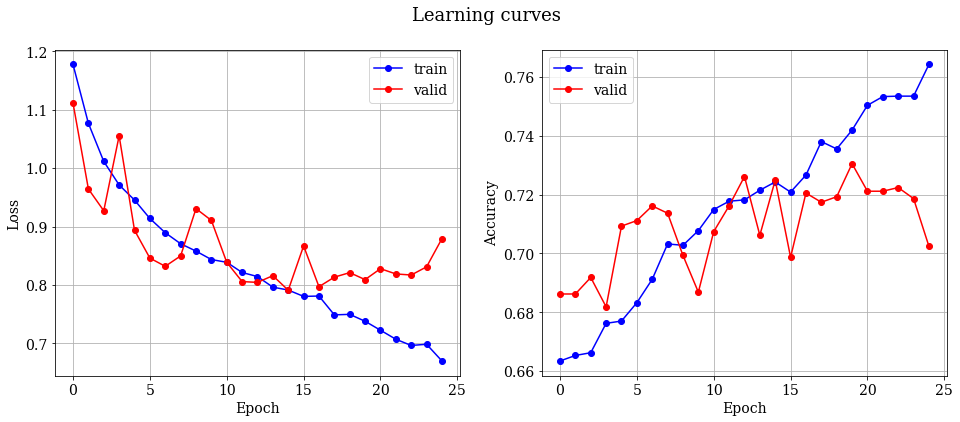

In [8]:
plot_learning_curve(history.history)

In [9]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 72.09
Recall    : 30.85
Precision : 67.15
F1        : 68.21


In [10]:
# Build a single 2D-CNN network
wide_cnn = get_wide_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
wide_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = wide_cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=25
)


Epoch 1/25
201/201 [==============================] - 2s 7ms/step - loss: 1.1913 - acc: 0.6642 - val_loss: 1.1543 - val_acc: 0.6862
Epoch 2/25
201/201 [==============================] - 1s 5ms/step - loss: 1.1087 - acc: 0.6653 - val_loss: 1.0196 - val_acc: 0.6862
Epoch 3/25
201/201 [==============================] - 1s 5ms/step - loss: 1.0386 - acc: 0.6644 - val_loss: 0.9443 - val_acc: 0.6981
Epoch 4/25
201/201 [==============================] - 1s 5ms/step - loss: 0.9910 - acc: 0.6697 - val_loss: 1.0208 - val_acc: 0.6875
Epoch 5/25
201/201 [==============================] - 1s 5ms/step - loss: 0.9674 - acc: 0.6753 - val_loss: 0.9102 - val_acc: 0.7068
Epoch 6/25
201/201 [==============================] - 1s 5ms/step - loss: 0.9189 - acc: 0.6834 - val_loss: 0.8536 - val_acc: 0.7093
Epoch 7/25
201/201 [==============================] - 1s 5ms/step - loss: 0.8978 - acc: 0.6926 - val_loss: 0.8477 - val_acc: 0.7187
Epoch 8/25
201/201 [==============================] - 1s 5ms/step - loss: 0.

In [11]:
history_wide_cnn = history.history

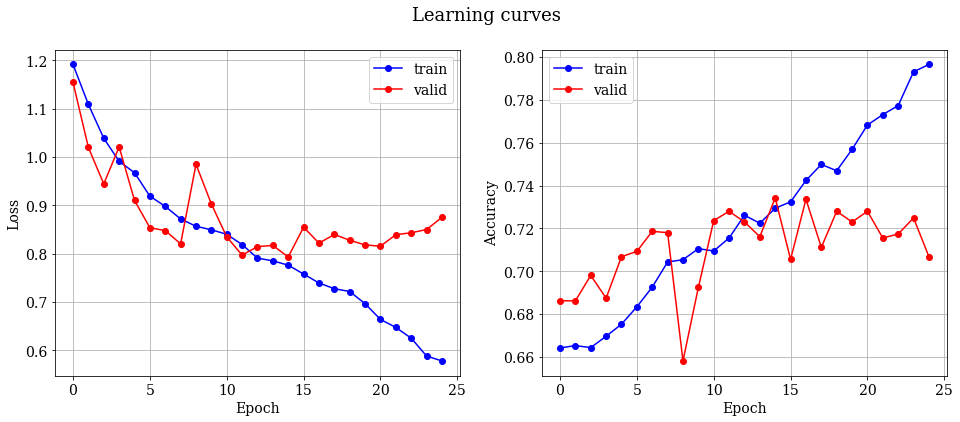

In [12]:
plot_learning_curve(history.history)

In [13]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = wide_cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 69.95
Recall    : 33.98
Precision : 67.60
F1        : 68.51


In [14]:
# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=25
)

Epoch 1/25
201/201 [==============================] - 3s 8ms/step - loss: 1.0863 - acc: 0.6639 - val_loss: 1.0139 - val_acc: 0.6900
Epoch 2/25
201/201 [==============================] - 1s 7ms/step - loss: 0.9642 - acc: 0.6775 - val_loss: 0.9028 - val_acc: 0.6925
Epoch 3/25
201/201 [==============================] - 1s 7ms/step - loss: 0.9140 - acc: 0.6831 - val_loss: 0.8515 - val_acc: 0.7112
Epoch 4/25
201/201 [==============================] - 1s 7ms/step - loss: 0.8938 - acc: 0.6904 - val_loss: 1.0264 - val_acc: 0.6999
Epoch 5/25
201/201 [==============================] - 1s 7ms/step - loss: 0.8902 - acc: 0.6956 - val_loss: 0.8308 - val_acc: 0.7224
Epoch 6/25
201/201 [==============================] - 1s 7ms/step - loss: 0.8699 - acc: 0.6984 - val_loss: 0.8203 - val_acc: 0.7205
Epoch 7/25
201/201 [==============================] - 1s 7ms/step - loss: 0.8596 - acc: 0.7015 - val_loss: 0.8350 - val_acc: 0.7168
Epoch 8/25
201/201 [==============================] - 1s 6ms/step - loss: 0.

In [15]:
history_cnn_tda = history.history

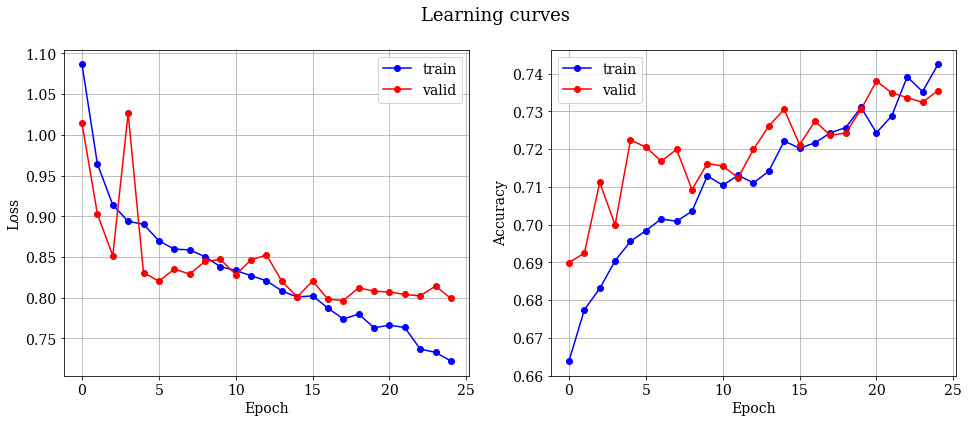

In [16]:
plot_learning_curve(history.history)

In [17]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 73.64
Recall    : 32.88
Precision : 69.51
F1        : 70.37


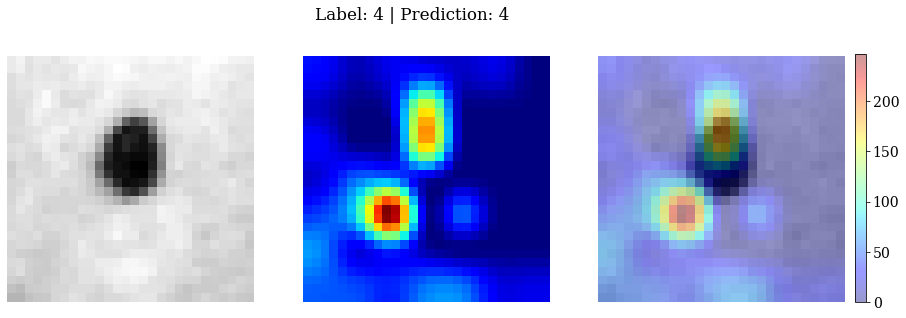

In [18]:
idx = 0
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

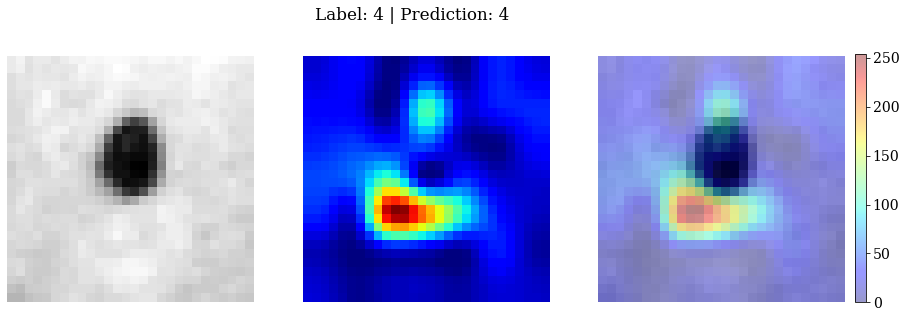

In [19]:
idx = 0
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(wide_cnn, layer_name='conv2d_8')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

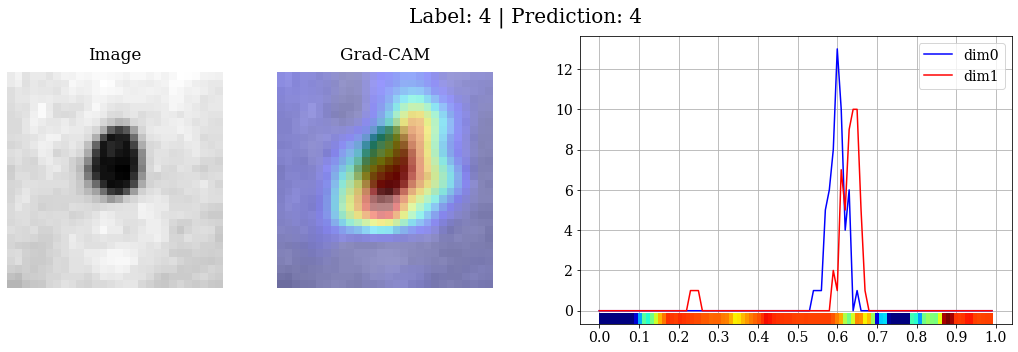

In [20]:
idx = 0
img = X_img_valid[idx:idx+1]
tda = X_tda_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_13', global_layer_name='conv1d_8')
gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
gradcam_cnn_tda.visualize()

In [21]:
# cnn.save(os.path.join(dir_ckpt, f'hmnist_cnn_seed{seed}'))
# wide_cnn.save(os.path.join(dir_ckpt, f'hmnist_wide_cnn_seed{seed}'))
# cnn_tda.save(os.path.join(dir_ckpt, f'hmnist_cnn_tda_seed{seed}'))

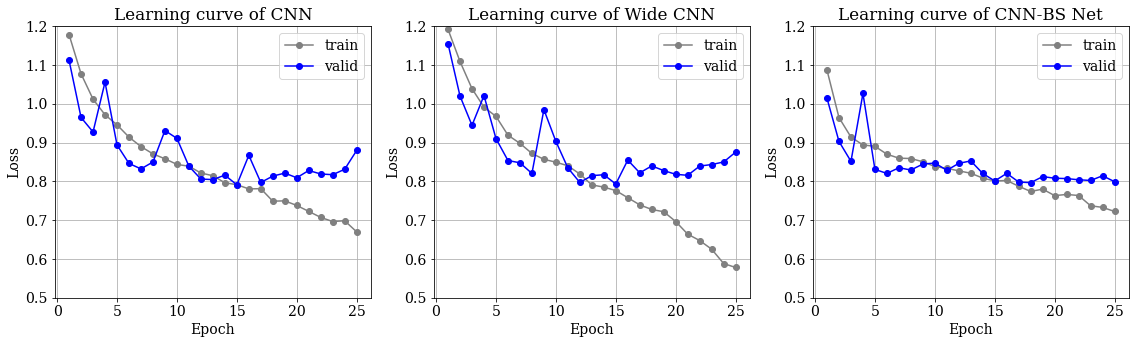

In [22]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
epoch = np.arange(len(history_cnn['loss'])) + 1

axes[0].plot(epoch, history_cnn['loss'], 'o-', c='gray', label='train')
axes[0].plot(epoch, history_cnn['val_loss'], 'bo-', label='valid')
axes[0].set_title('Learning curve of CNN')
axes[1].plot(epoch, history_wide_cnn['loss'], 'o-', c='gray', label='train')
axes[1].plot(epoch, history_wide_cnn['val_loss'], 'bo-', label='valid')
axes[1].set_title('Learning curve of Wide CNN')
axes[2].plot(epoch, history_cnn_tda['loss'], 'o-', c='gray', label='train')
axes[2].plot(epoch, history_cnn_tda['val_loss'], 'bo-', label='valid')
axes[2].set_title('Learning curve of CNN-BS Net')
for i in range(3):
    axes[i].grid(axis='both')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_xticks(ticks=np.arange(0, len(epoch) + 1, 5))
    axes[i].legend()
    axes[i].set_ylim(0.50, 1.2)

fig.tight_layout()
plt.savefig('./outputs/figures/learning_curves.pdf', dpi=100)
plt.show()

In [23]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_network (Sequential)    (None, 256)               392320    
                                                                 
 head (Sequential)           (None, 7)                 264711    
                                                                 
Total params: 657,031
Trainable params: 657,031
Non-trainable params: 0
_________________________________________________________________


In [24]:
wide_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_network (Sequential)    (None, 256)               977920    
                                                                 
 head (Sequential)           (None, 7)                 264711    
                                                                 
Total params: 1,242,631
Trainable params: 1,242,631
Non-trainable params: 0
_________________________________________________________________


In [25]:
cnn_tda.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 2)]     0           []                               
                                                                                                  
 img_network (Sequential)       (None, 256)          392320      ['input_2[0][0]']                
                                                                                                  
 tda_network (Sequential)       (None, 1000)         6058        ['input_3[0][0]']                
                                                                                              